# 🤔Brief
Selfnotes:
- Always ask yourself, how can I make this even more simple?
- Be good at explaining. Explain it like Feynman.
- By explaining well, you give yourself direction.

**Introduction:** The client is a large grocery store in Ecuador that wants to be more efficient in stocking inventory.

**Problem:** If inventory is oversupplied, unsold items will go to waste and are cost to the grocery. If inventory is undersupplied, there wouldn't be enough items to sell that meets demand and they would miss the opportunity to earn more money.

**Hypothesis:** If we are able to know how much inventory to supply in a given day, then we would minimize the cost of oversupplying items that does not sell and goes to waste. And maximizing revenue by having enough supply of items that we know will be in demand.

**Goal:** To predict and forecast the inventory needed to meet the demand of market.

-----
[Overview](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

[Kaggle](https://www.kaggle.com/code/fiftythirtyfour/store-sales/)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 400
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')

## Clean
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.isocalendar().week
df['year'] = df['date'].dt.year
df['weekname'] = df.date.dt.day_name()
df['dayofyear'] = df['date'].dt.strftime('%j')
df['store_nbr'] = df['store_nbr'].astype(str) ## Didn't want the order of numbers to influence the model.

transactions['date'] = pd.to_datetime(transactions['date'])
transactions['store_nbr'] = transactions['store_nbr'].astype(str)
stores['store_nbr'] = stores['store_nbr'].astype(str)
stores['cluster'] = stores['cluster'].astype(str)
df = pd.merge(df, stores, on='store_nbr')
df = pd.merge(df, transactions, on=['store_nbr', 'date'])

## Organize
target = 'sales'
cat = [x for x in df.columns if df.dtypes[x] == 'object']
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float64')]
num.remove('id')
num.remove('sales')

## train test split
train = df.loc[df['date'].dt.year != 2017]
test = df.loc[df['date'].dt.year == 2017]

# 🤓Data
Selfnotes:
- Always start with Correlation.
- Be free to explore. Be good at doing graphs in seaborn.
- Always contain your graphs using "g" variable and overwrite it for the next graph.
- You don't have to explore all columns. Always start with correlation and work your way down.
- Remember, that creative features always wins over choosing the best model.



















In [2]:
train.corr(numeric_only=True)[target].sort_values(ascending=False)

sales           1.000000
onpromotion     0.377280
transactions    0.214289
id              0.070857
year            0.064990
week            0.029661
Name: sales, dtype: float64

## Finding Large Stores
I am looking for big stores that have consistent data throughout the years so that I can limit the noise.

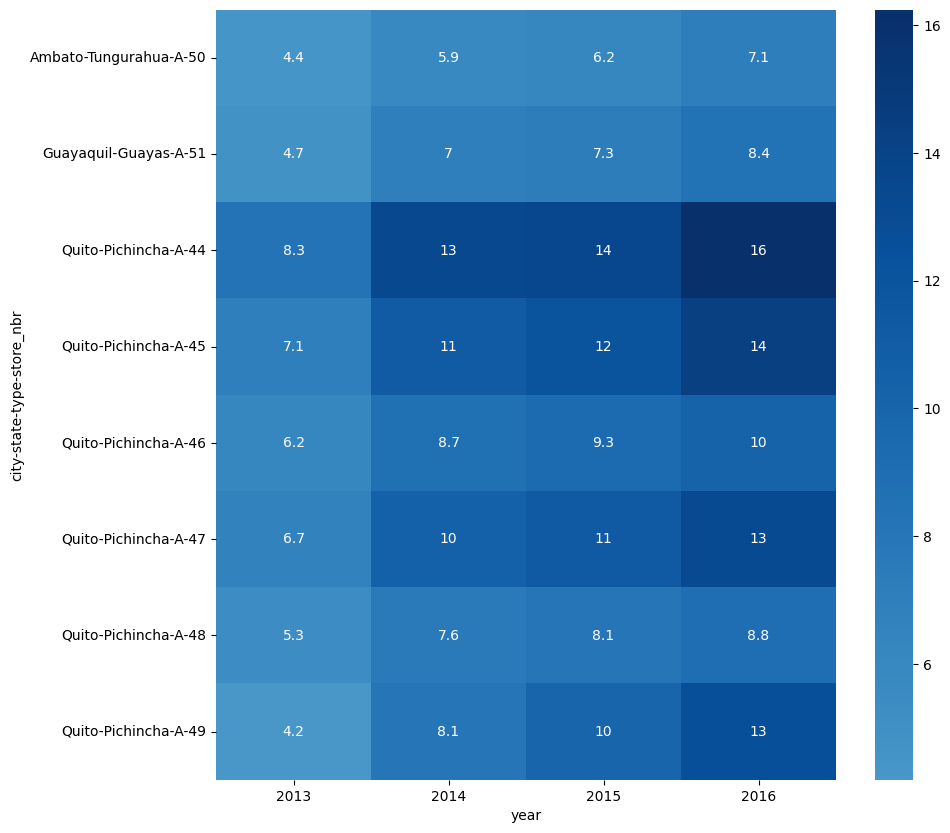

In [3]:
g = train.query('type=="A"')
g = g.pivot_table(target, index=['city', 'state', 'type', 'store_nbr'], columns='year', aggfunc='sum') /1000000
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(g, center=1, cmap='Blues', annot=True);

## Items with largest volume and volatility
Type A stores have more data. Will focus on this. Now, I need to see which products have the largest volume and deviations. The products that have low volume and does not have big swings, I will just use the average or zeros.

In [4]:
g = train.query('type=="A"')
g = g.groupby('family')[target].agg(['sum', 'std'])
g.sort_values(['sum'], ascending=False )
# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(g, center=1, cmap='Oranges', annot=True);

,sum,std
family,,
GROCERY I,8.775302e+07,3395.845389
BEVERAGES,5.717556e+07,3099.676652
PRODUCE,3.517733e+07,3618.258507
CLEANING,2.362948e+07,790.138897
DAIRY,1.909365e+07,806.316772
POULTRY,1.102969e+07,504.659631
BREAD/BAKERY,1.062232e+07,405.641033
MEATS,1.040025e+07,361.546946
PERSONAL CARE,6.354052e+06,307.390677


## Sales vs Onpromotion
- By the end of the year, almost all the groceries are on sale. Sales go down also. Most probably after the holidays.
- A lot of the sale starts by November to December.
- GROCERY I and GROCERY II seems to be the same?

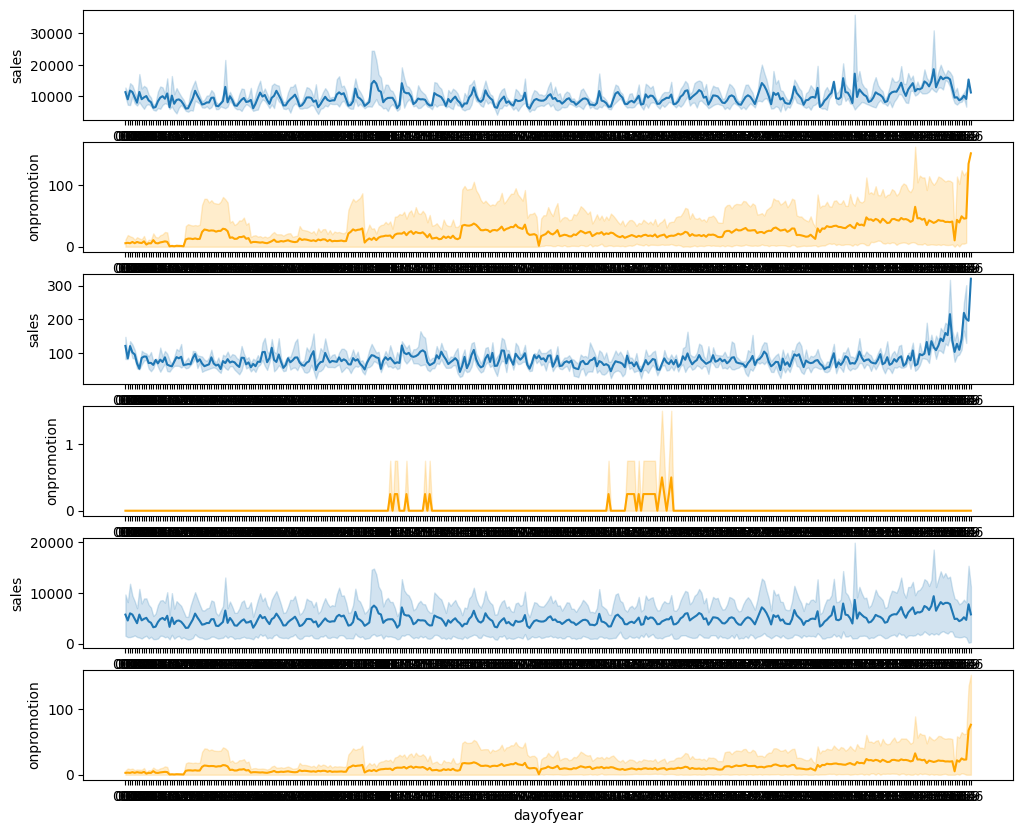

In [5]:
g = train.query('store_nbr == "44"')
fig, ax = plt.subplots(6, figsize=(12, 10))

sns.lineplot(g.query('family == "GROCERY I"'), x='dayofyear', y=target, ax=ax[0]);
sns.lineplot(g.query('family == "GROCERY I"'), x='dayofyear', y='onpromotion', ax=ax[1], color='orange');

sns.lineplot(g.query('family == "GROCERY II"'), x='dayofyear', y=target, ax=ax[2]);
sns.lineplot(g.query('family == "GROCERY II"'), x='dayofyear', y='onpromotion', ax=ax[3], color='orange');

sns.lineplot(g.loc[g['family'].str.startswith("GROCERY")], x='dayofyear', y=target, ax=ax[4]);
sns.lineplot(g.loc[g['family'].str.startswith("GROCERY")], x='dayofyear', y='onpromotion', ax=ax[5], color='orange');

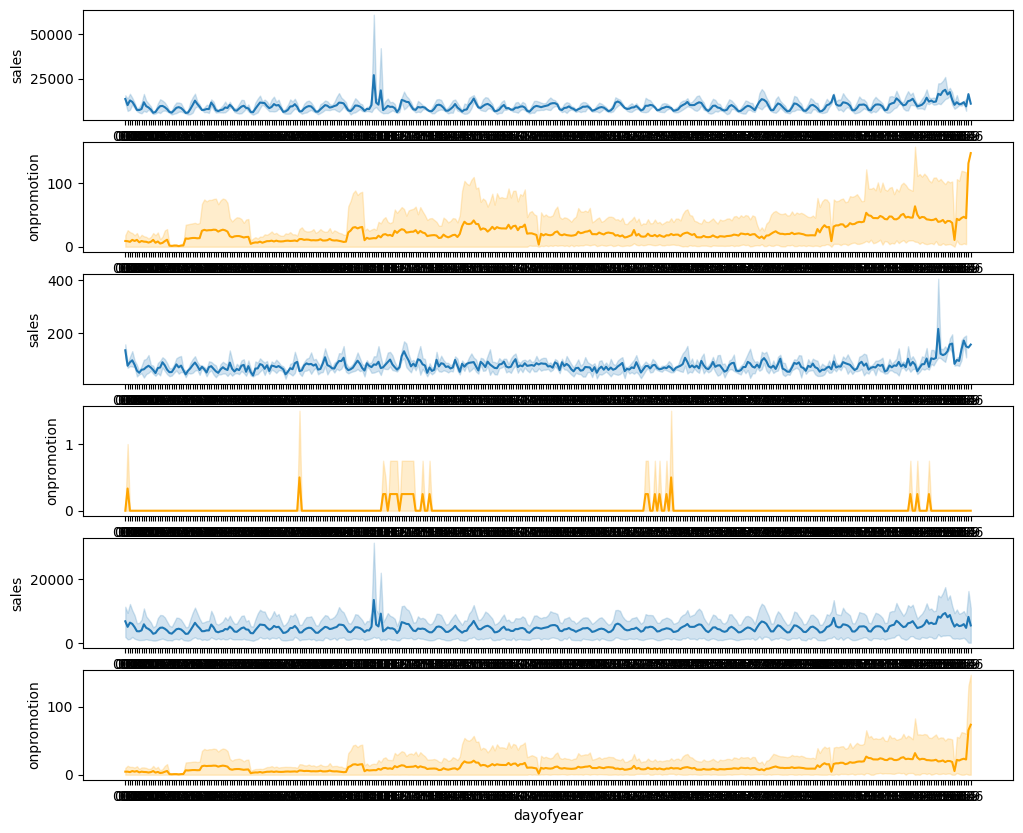

In [6]:
g = train.query('store_nbr == "45"')
fig, ax = plt.subplots(6, figsize=(12, 10))

sns.lineplot(g.query('family == "GROCERY I"'), x='dayofyear', y=target, ax=ax[0]);
sns.lineplot(g.query('family == "GROCERY I"'), x='dayofyear', y='onpromotion', ax=ax[1], color='orange');

sns.lineplot(g.query('family == "GROCERY II"'), x='dayofyear', y=target, ax=ax[2]);
sns.lineplot(g.query('family == "GROCERY II"'), x='dayofyear', y='onpromotion', ax=ax[3], color='orange');

sns.lineplot(g.loc[g['family'].str.startswith("GROCERY")], x='dayofyear', y=target, ax=ax[4]);
sns.lineplot(g.loc[g['family'].str.startswith("GROCERY")], x='dayofyear', y='onpromotion', ax=ax[5], color='orange');

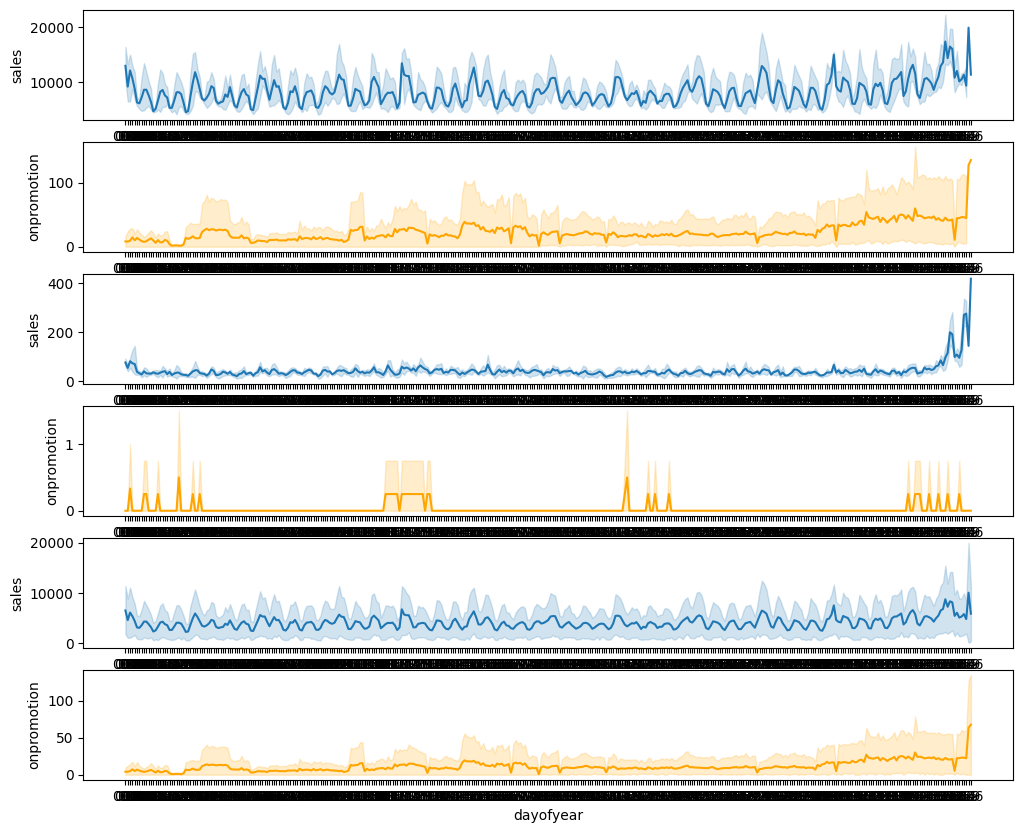

In [7]:
g = train.query('store_nbr == "46"')
fig, ax = plt.subplots(6, figsize=(12, 10))

sns.lineplot(g.query('family == "GROCERY I"'), x='dayofyear', y=target, ax=ax[0]);
sns.lineplot(g.query('family == "GROCERY I"'), x='dayofyear', y='onpromotion', ax=ax[1], color='orange');

sns.lineplot(g.query('family == "GROCERY II"'), x='dayofyear', y=target, ax=ax[2]);
sns.lineplot(g.query('family == "GROCERY II"'), x='dayofyear', y='onpromotion', ax=ax[3], color='orange');

sns.lineplot(g.loc[g['family'].str.startswith("GROCERY")], x='dayofyear', y=target, ax=ax[4]);
sns.lineplot(g.loc[g['family'].str.startswith("GROCERY")], x='dayofyear', y='onpromotion', ax=ax[5], color='orange');

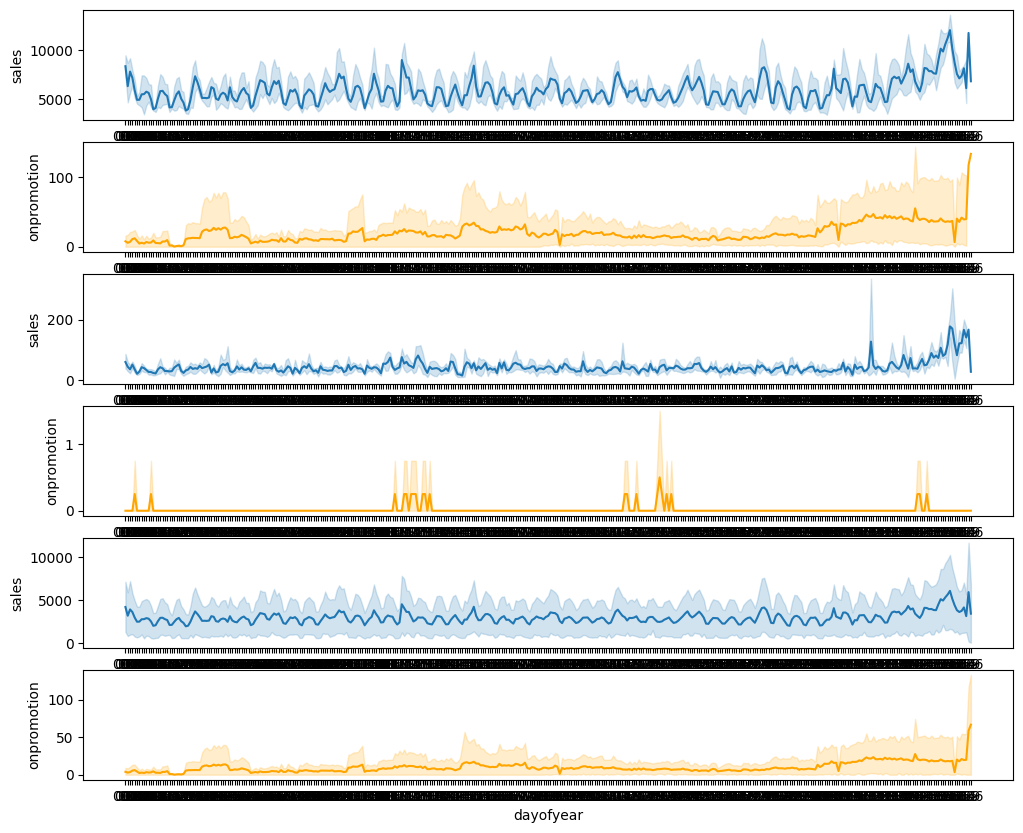

In [8]:
g = train.query('store_nbr == "50"')
fig, ax = plt.subplots(6, figsize=(12, 10))

sns.lineplot(g.query('family == "GROCERY I"'), x='dayofyear', y=target, ax=ax[0]);
sns.lineplot(g.query('family == "GROCERY I"'), x='dayofyear', y='onpromotion', ax=ax[1], color='orange');

sns.lineplot(g.query('family == "GROCERY II"'), x='dayofyear', y=target, ax=ax[2]);
sns.lineplot(g.query('family == "GROCERY II"'), x='dayofyear', y='onpromotion', ax=ax[3], color='orange');

sns.lineplot(g.loc[g['family'].str.startswith("GROCERY")], x='dayofyear', y=target, ax=ax[4]);
sns.lineplot(g.loc[g['family'].str.startswith("GROCERY")], x='dayofyear', y='onpromotion', ax=ax[5], color='orange');

# 🤖Model
Selfnotes:
- How can I put the data cleaning bit in Dataselect?
- Choose the features you use. Not all are useful.
- You have to visualize your residuals. Ask Ageron, how.

## Pipes

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, att):
        self.att = att
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['store_nbr'] = X['store_nbr'].astype(str)
        return X[self.att]

In [10]:
num_pp = Pipeline([
    ('dataselect', DataSelect(['onpromotion']))
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(['family', 'store_nbr']))
    , ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

pipe = FeatureUnion([
    ('numeric', num_pp)
#     , ('cat', cat_pp)
])

pipe.fit(train)
train_pp = pipe.transform(train)
test_pp = pipe.transform(test)

## Baseline

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [12]:
reg_lin = LinearRegression()
reg_lin.fit(train_pp, train[target])
np.sqrt(
    -cross_val_score(
        reg_lin, train_pp, train[target], scoring='neg_mean_squared_error').mean()
)

1019.9100638635726

## Residual Analysis

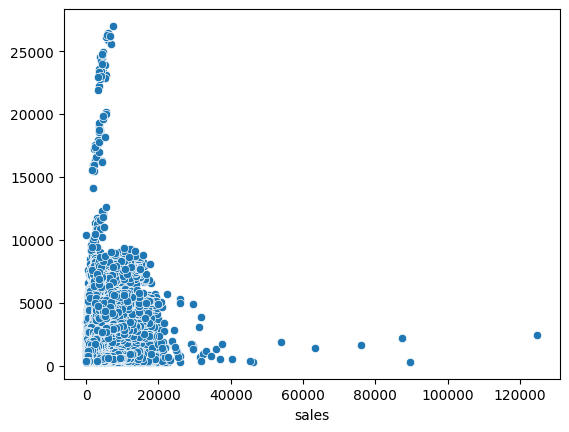

In [13]:
x = train[target]
y = reg_lin.predict(train_pp)
# plt.scatter(x,y);
sns.scatterplot(x=x,y=y);

## Submission

In [14]:
samp = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
pd.DataFrame({
    'id': samp['id']
    , 'sales': reg_lin.predict(pipe.transform(samp))
}).to_csv('submission.csv', index=False)

# 📌Notes
- ❓There is something around Sep-Oct for the year 2016. No one is buying stuff for store number 25.
- 💎There seems to more Produce being sold on Wednesdays.
- 💎On Promotion is big factor of selling but it needs to reach a certain threshold to take effect.

## Editor's Notes
- Iteration is key. The more versions of my machines, the better I make it. Get feedback. Look at notebooks of others.
- You need to know what to do every single time you open a notebook. You must be comfortable at exploring the data. FU the model. Be creative on finding good features. This is what matters.